## Fraudulent Job Detection (NLP and Classification)
Binary classifies job posts as fraudulent or legitimate. Uses regex to clean the description data and nltk to preprocess and remove stopwords. An XGBOOST model with fine-tuning is used for model training.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import datetime as dt
from sklearn.decomposition import PCA                   
from sklearn.svm import SVC                             
from sklearn.pipeline import make_pipeline              
from sklearn.model_selection import train_test_split    
from sklearn.model_selection import GridSearchCV        
from sklearn import metrics
import random
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from collections import defaultdict
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

plt.rcParams["figure.figsize"]=(12,8)

### Get the data used for this project: 
Real / Fake Job Posting Prediction: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

Data Cleaning Reference Credit: https://www.kaggle.com/code/sudhanshu2198/us-fraudulent-job-posting-prediction-nlp

## Data Validation & Cleaning
This data set has 17880 rows, 18 columns.
- job_id
- title
- location
- department
- salary_range
- company_profile
- description
- requirements
- benefit
- telecommuting
- has_company_logo
- has_question
- employment_type
- required_experience
- required_education
- industry
- function
- fraudulent

In [2]:
df = pd.read_csv('C:/fakejob/fake_job_postings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

### Split the Dataset in half (If running without a GPU)

len(df) / 2

df = df.sample(n = 8940, random_state=2025)
df.shape

df.head()

In [3]:
df.describe().T

count         mean          std  min      25%     50%  \
job_id            17880.0  8940.500000  5161.655742  1.0  4470.75  8940.5   
telecommuting     17880.0     0.042897     0.202631  0.0     0.00     0.0   
has_company_logo  17880.0     0.795302     0.403492  0.0     1.00     1.0   
has_questions     17880.0     0.491723     0.499945  0.0     0.00     0.0   
fraudulent        17880.0     0.048434     0.214688  0.0     0.00     0.0   

                       75%      max  
job_id            13410.25  17880.0  
telecommuting         0.00      1.0  
has_company_logo      1.00      1.0  
has_questions         1.00      1.0  
fraudulent            0.00      1.0

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [7]:
df.drop(['location', 'job_id', 'salary_range', 'title'], axis=1, inplace=True)

In [8]:
data=df.select_dtypes(include="object")
cols=data.columns

In [9]:
#replace missing data with empty string
df[cols]= df[cols].replace(np.nan,"")

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SAIJYOTHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAIJYOTHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
df['Job_Description'] = ""
for col in data.columns:
    df['Job_Description'] = df['Job_Description']+" "+df[col]
df['Job_Description'].iloc[1]

" Success 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L’Oreal, Sony and Barclays and has offic

### Create features- specify whether the data has been provided or not (uses 1 for yes and 0 for no)

In [13]:
def feature(info):
    if info== "":
        return 0
    else:
        return 1

In [14]:
for col in cols:
    df[col]= df[col].apply(feature)

In [15]:
df.head()

department  company_profile  description  requirements  benefits  \
0           1                1            1             1         0   
1           1                1            1             1         1   
2           0                1            1             1         0   
3           1                1            1             1         1   
4           0                1            1             1         1   

   telecommuting  has_company_logo  has_questions  employment_type  \
0              0                 1              0                1   
1              0                 1              0                1   
2              0                 1              0                0   
3              0                 1              0                1   
4              0                 1              1                1   

   required_experience  required_education  industry  function  fraudulent  \
0                    1                   0         0         1           0   
1                    1                   0         1         1           0   
2                    0                   0         0         0           0   
3                    1                   1         1         1           0   
4                    1                   1         1         1           0   

                                     Job_Description  
0   Marketing We're Food52, and we've created a g...  
1   Success 90 Seconds, the worlds Cloud Video Pr...  
2    Valor Services provides Workforce Solutions ...  
3   Sales Our passion for improving quality of li...  
4    SpotSource Solutions LLC is a Global Human C...

In [16]:
df.isna().sum()

department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Job_Description        0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   department           17880 non-null  int64 
 1   company_profile      17880 non-null  int64 
 2   description          17880 non-null  int64 
 3   requirements         17880 non-null  int64 
 4   benefits             17880 non-null  int64 
 5   telecommuting        17880 non-null  int64 
 6   has_company_logo     17880 non-null  int64 
 7   has_questions        17880 non-null  int64 
 8   employment_type      17880 non-null  int64 
 9   required_experience  17880 non-null  int64 
 10  required_education   17880 non-null  int64 
 11  industry             17880 non-null  int64 
 12  function             17880 non-null  int64 
 13  fraudulent           17880 non-null  int64 
 14  Job_Description      17880 non-null  object
dtypes: int64(14), object(1)
memory usage: 2.0+ MB


### The amount of real jobs (labeled 0) vs fraud jobs (labeled 1) in this dataset

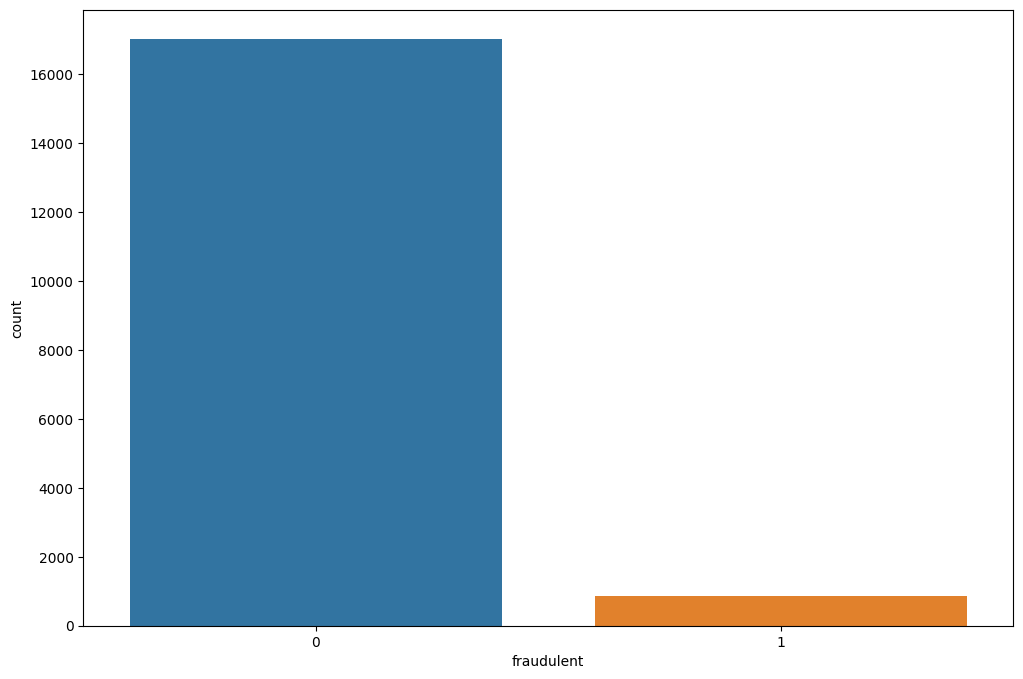

In [18]:
sns.countplot(x='fraudulent', data=df)
plt.show()

### Create feature for Job Description length

In [19]:
df['job_description'] = df['Job_Description']
df.drop(['Job_Description'], axis=1, inplace=True)

In [20]:
df['description_length'] = df['job_description'].str.len()

In [21]:
df['description'].value_counts()

description
1    17879
0        1
Name: count, dtype: int64

In [22]:
df.columns

Index(['department', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'job_description',
       'description_length'],
      dtype='object')

### Correlation across variables

In [23]:
features=['department', 'company_profile', 'requirements','description',
          'benefits', 'employment_type', 'required_experience',
          'required_education', 'industry', 'function','fraudulent']

In [24]:
df[features].corr()

department  company_profile  requirements  description  \
department             1.000000         0.065252      0.110427     0.005539   
company_profile        0.065252         1.000000      0.102723     0.015697   
requirements           0.110427         0.102723      1.000000     0.017748   
description            0.005539         0.015697      0.017748     1.000000   
benefits               0.152190         0.099736      0.426144     0.009096   
employment_type       -0.011409         0.112095      0.173724     0.015238   
required_experience    0.108654         0.065332      0.267683     0.009269   
required_education     0.039405         0.091278      0.286619     0.008213   
industry               0.027423         0.091010      0.223769     0.012167   
function               0.178789         0.081194      0.284965     0.009950   
fraudulent             0.015398        -0.286330     -0.017052    -0.033149   

                     benefits  employment_type  required_experience  \
department           0.152190        -0.011409             0.108654   
company_profile      0.099736         0.112095             0.065332   
requirements         0.426144         0.173724             0.267683   
description          0.009096         0.015238             0.009269   
benefits             1.000000         0.141224             0.196274   
employment_type      0.141224         1.000000             0.540900   
required_experience  0.196274         0.540900             1.000000   
required_education   0.236069         0.469697             0.595475   
industry             0.195586         0.706249             0.597659   
function             0.189737         0.514300             0.637826   
fraudulent          -0.007803        -0.048007            -0.049865   

                     required_education  industry  function  fraudulent  
department                     0.039405  0.027423  0.178789    0.015398  
company_profile                0.091278  0.091010  0.081194   -0.286330  
requirements                   0.286619  0.223769  0.284965   -0.017052  
description                    0.008213  0.012167  0.009950   -0.033149  
benefits                       0.236069  0.195586  0.189737   -0.007803  
employment_type                0.469697  0.706249  0.514300   -0.048007  
required_experience            0.595475  0.597659  0.637826   -0.049865  
required_education             1.000000  0.539044  0.546412   -0.030584  
industry                       0.539044  1.000000  0.574225   -0.021915  
function                       0.546412  0.574225  1.000000   -0.013212  
fraudulent                    -0.030584 -0.021915 -0.013212    1.000000

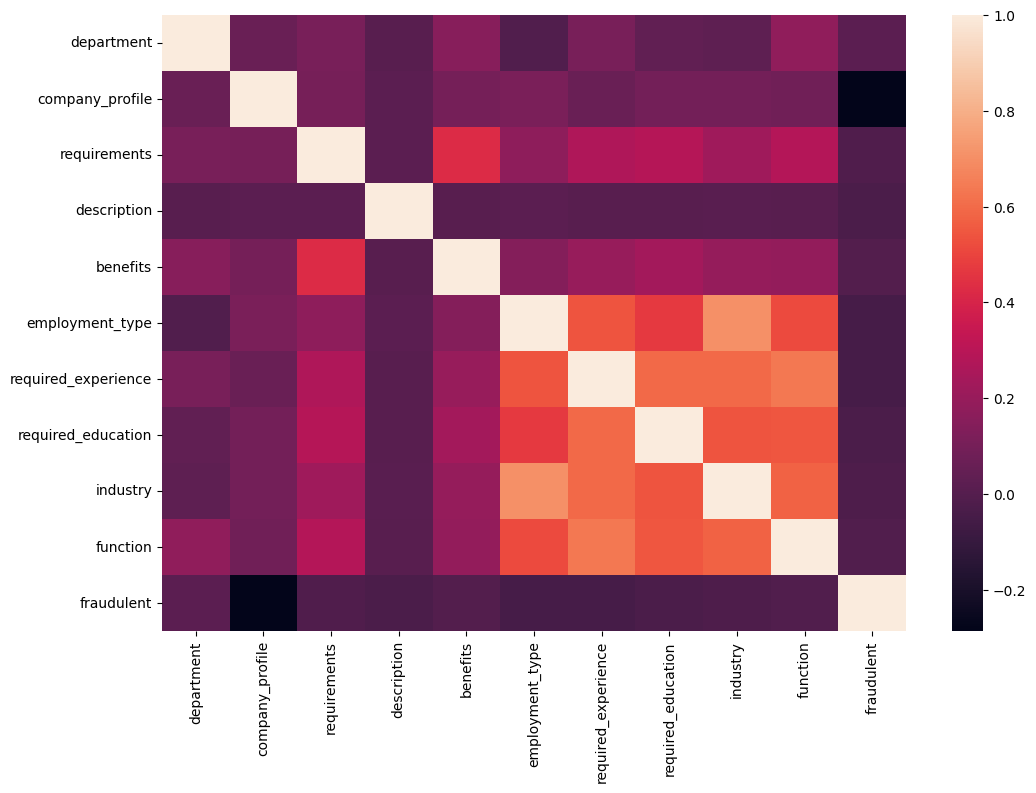

In [25]:
sns.heatmap(df[features].corr())
plt.show()

## Tokenization

### Removing stop words

In [26]:
stop=set(stopwords.words("english"))
df["job_description"].iloc[1]

" Success 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L’Oreal, Sony and Barclays and has offic

### Cleaning the text data in job_description using regex

In [27]:
def clean(text): 
    text=text.lower()
    obj=re.compile(r"<.*?>") #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+") #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]") #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}") #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+") #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s") #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}") #removing multiple spaces
    text=obj.sub(r" ",text)  
    
    stemmer = SnowballStemmer("english")
    text=[stemmer.stem(word) for word in text.split() if word not in stop]
    
    return " ".join(text)

In [28]:
df["job_description"]=df["job_description"].apply(clean)

In [29]:
df['job_description'].iloc[1]

'success second world cloud video product servic second world cloud video product servic enabl brand agenc get high qualiti onlin video content shot produc anywher world second make video product fast afford manag seamless cloud purchas publish second remov hassl cost risk speed issu work regular video product compani manag everi aspect video project beauti onlin experi grow global network rate video profession countri manag dedic product success team countri second provid success guarante second produc almost video countri global brand includ world largest includ paypal oreal soni barclay offic auckland london sydney tokyo singapor organis focus vibrant awesom passion custom servic slick type skill mayb account manag think administr cooler polar bear jetski need hear cloud video product servic opper glodal level yeah pretti cool serious deliv world class product excel custom servic rapid expand busi look talent project manag manag success deliveri video project manag client communic d

### Generate a WordCloud for real jobs

In [30]:
def generate(string,ngram):
    n_grams=ngrams(word_tokenize(text),ngram)
    grams=[" ".join(val) for val in n_grams]
    return grams

(-0.5, 599.5, 599.5, -0.5)

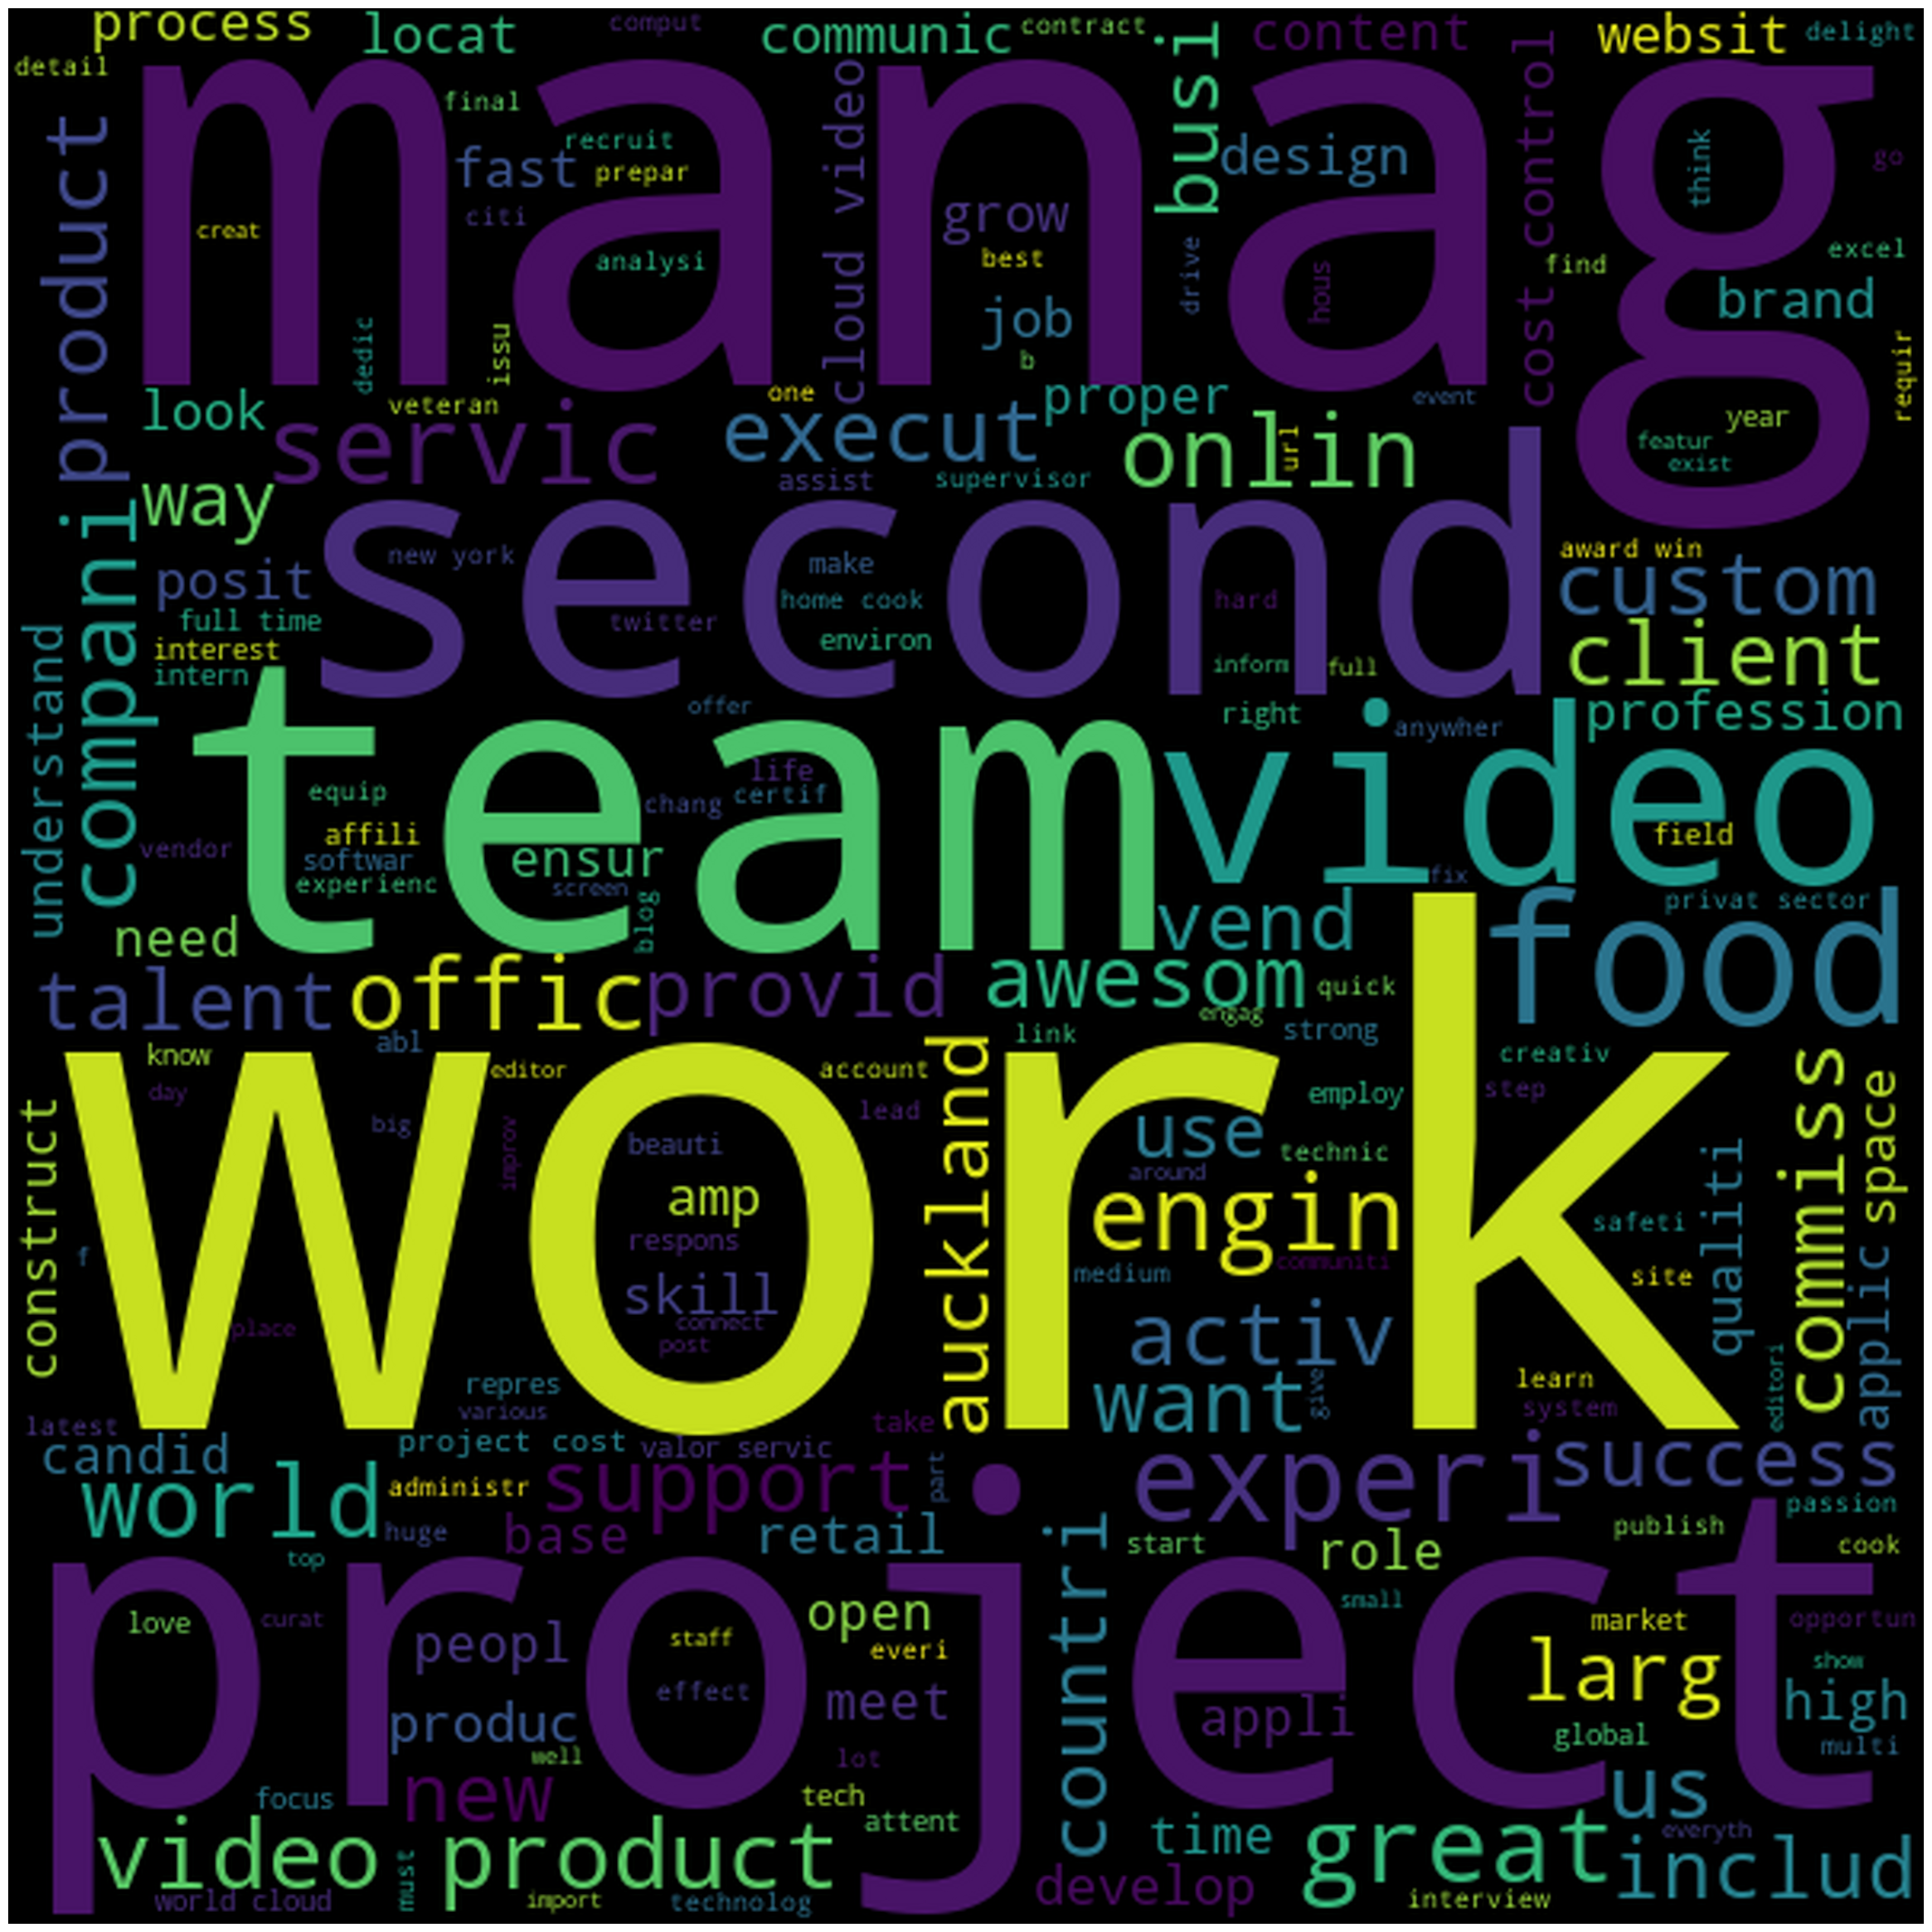

In [31]:
real = df[df['fraudulent']==0]['job_description'].values
cloud = WordCloud(width= 600, height= 600, stopwords= STOPWORDS, 
                      background_color='black').generate(str(real))

fig = plt.figure(figsize = (30, 30))
plt.imshow(cloud, interpolation= 'blackman')
plt.axis('off')

<BarContainer object of 10 artists>

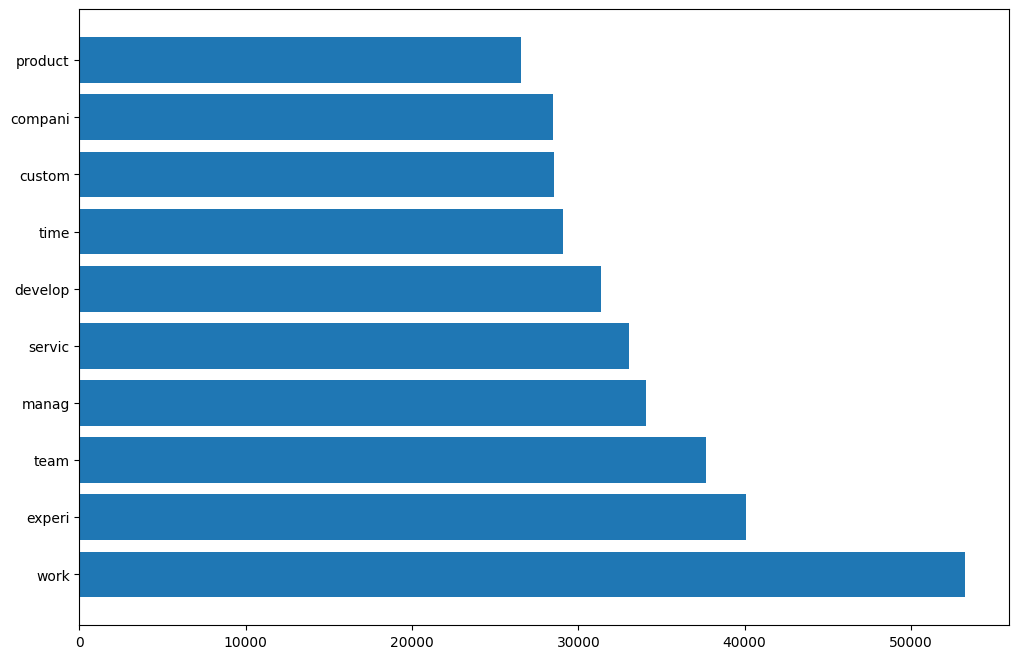

In [32]:
neg_1=defaultdict(int)

for text in df[df["fraudulent"]==0]["job_description"]:
    for words in generate(text,1):
        neg_1[words]+=1
        
neg=pd.DataFrame(sorted(neg_1.items(),key=lambda x: x[1],reverse=True))
plt.barh(neg[0][:10], neg[1][:10])

### Generate a WordCloud for fake jobs

(-0.5, 599.5, 599.5, -0.5)

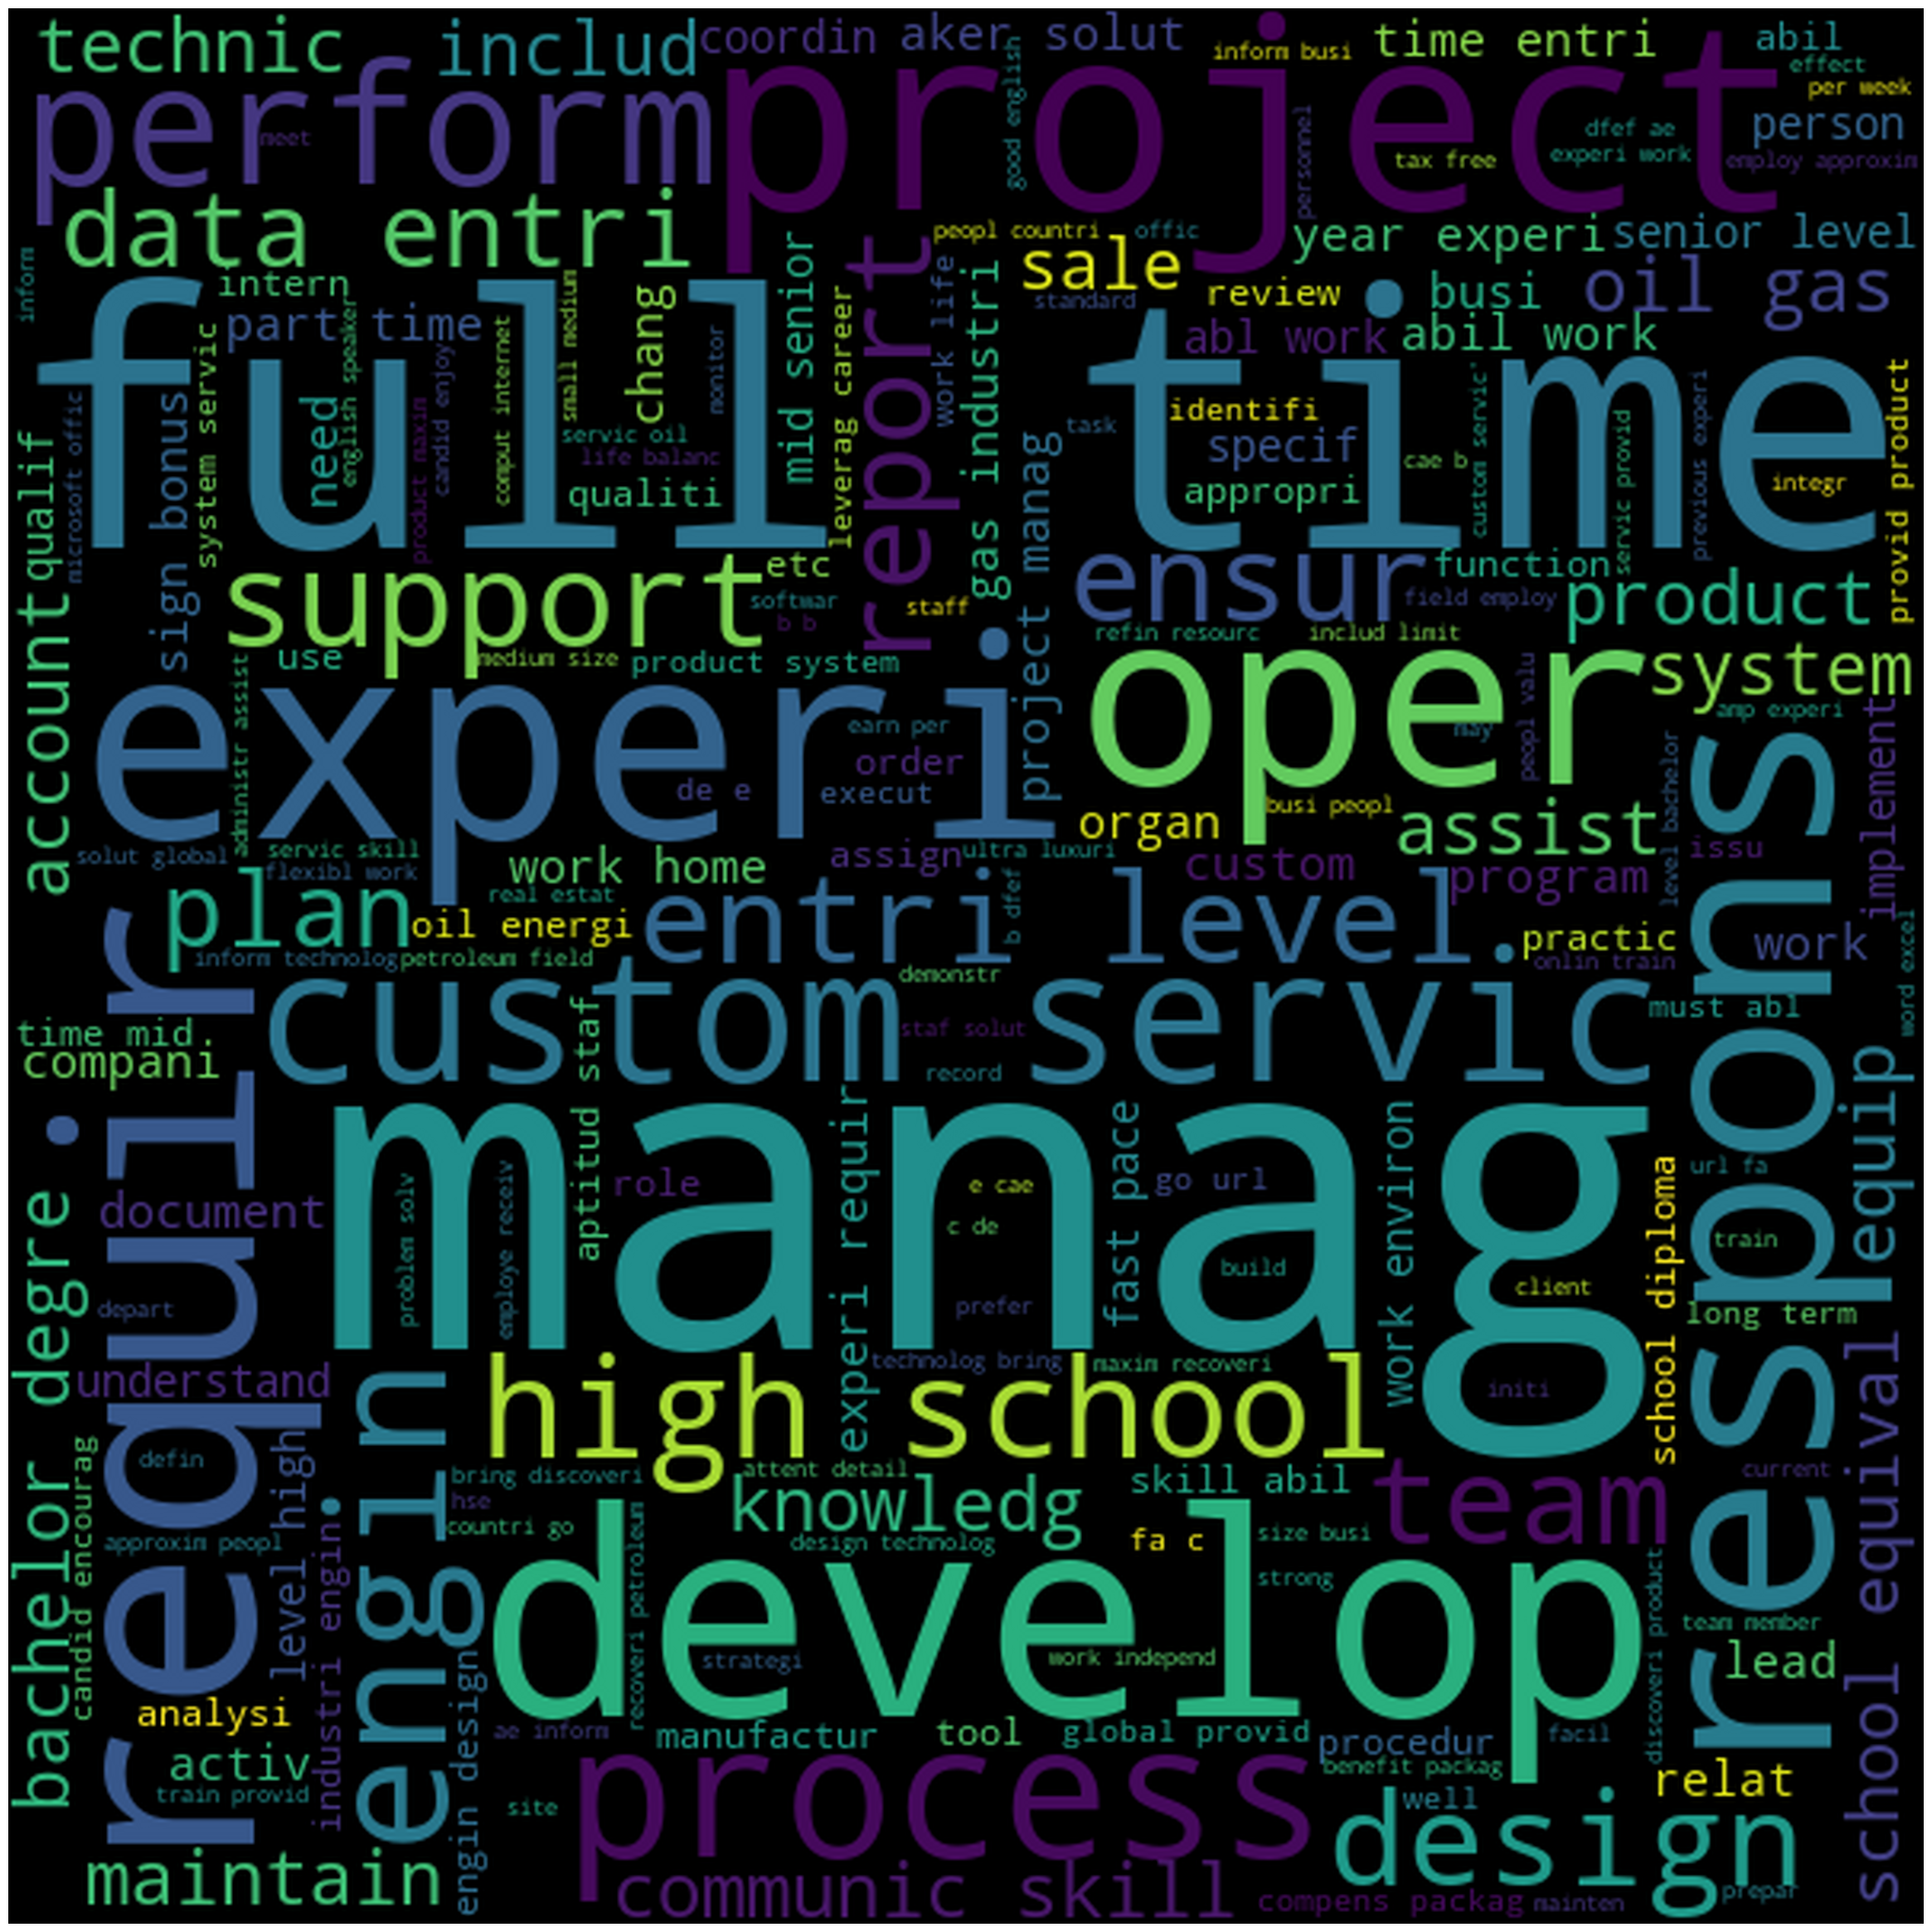

In [33]:
fake = df[df['fraudulent']==1]['job_description'].values
cloud = WordCloud(width= 600, height= 600, stopwords= STOPWORDS, 
                      background_color='black').generate(str(fake))

fig = plt.figure(figsize = (30, 30))
plt.imshow(cloud, interpolation= 'blackman')
plt.axis('off')

<BarContainer object of 10 artists>

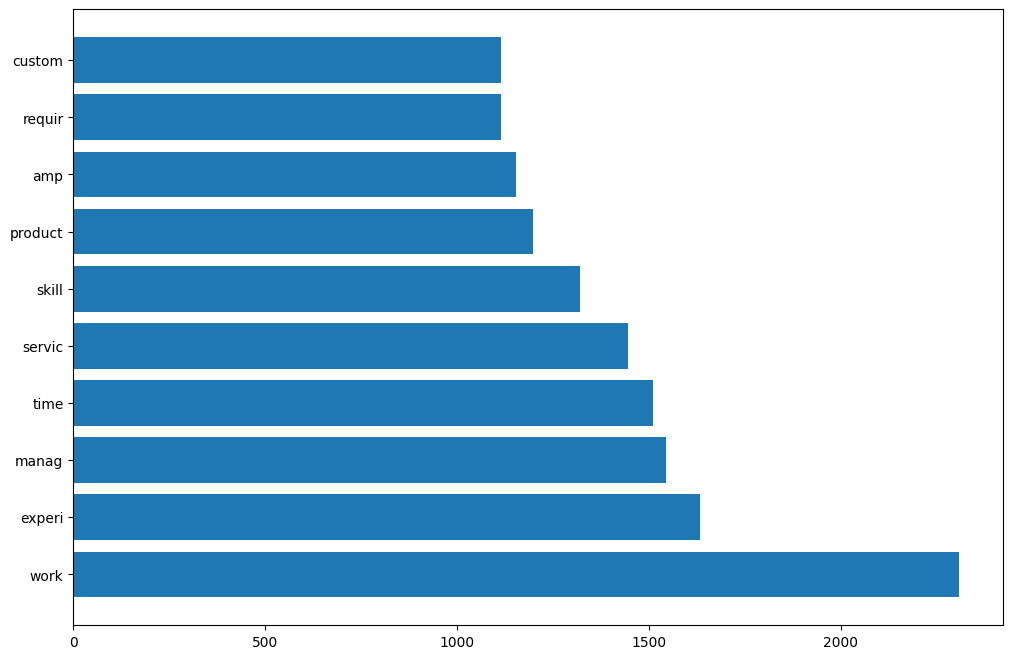

In [34]:
pos_1=defaultdict(int)

for text in df[df["fraudulent"]==1]["job_description"]:
    for words in generate(text,1):
        pos_1[words]+=1
        
pos=pd.DataFrame(sorted(pos_1.items(),key=lambda x: x[1],reverse=True))
plt.barh(pos[0][:10],pos[1][:10])

## Data Preprocessing & Model Fitting

In [35]:
vectorizer=TfidfVectorizer(strip_accents='unicode',
                           analyzer='word', ngram_range=(1, 2),
                           max_features=15000, smooth_idf=True,
                           sublinear_tf=True)

In [36]:
vectorizer.fit(df["job_description"])
X = vectorizer.transform(df["job_description"])

In [37]:
X.shape

(17880, 15000)

In [38]:
from sklearn.decomposition import IncrementalPCA

# Set a specific number of components, e.g., 100, based on desired reduction
pca = IncrementalPCA(n_components=100, batch_size=500)
X_transformed = pca.fit_transform(X)

In [39]:
X.shape

(17880, 15000)

<Axes: >

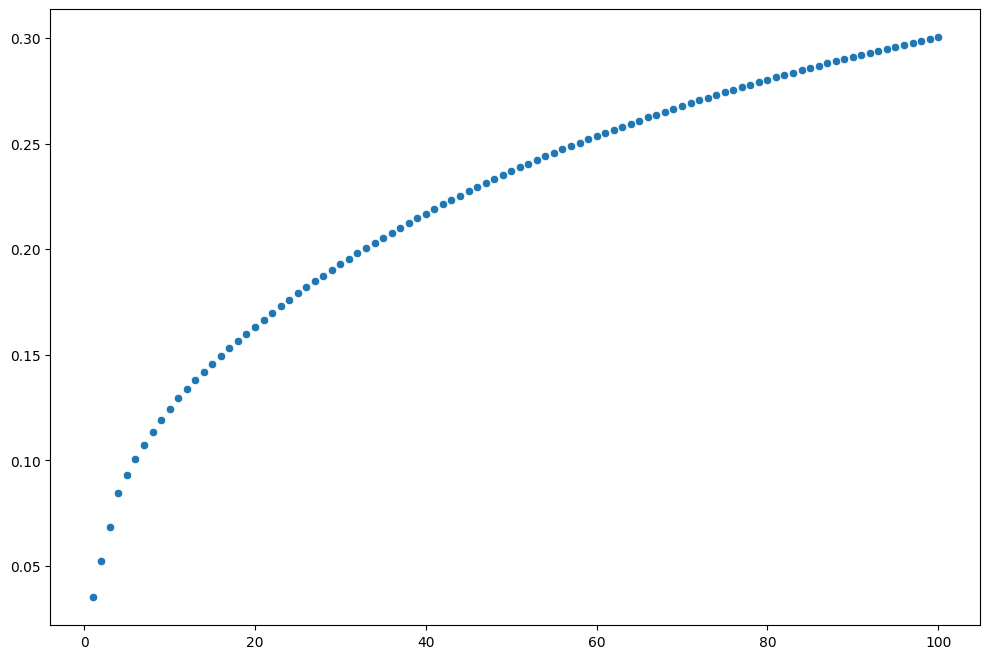

In [40]:
# Ensure PCA has been fitted before accessing explained_variance_ratio_
x = range(1, len(pca.explained_variance_ratio_) + 1)
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative variance
sns.scatterplot(x=x, y=cumulative_sum)

### Naive Bayes Model

In [41]:
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.25, 
                                                    random_state=2025)

In [42]:
nb = GaussianNB()
# Convert sparse matrices to dense
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Fit the model
nb.fit(X_train_dense, y_train)
y_pred = nb.predict(X_test_dense)

In [43]:
print(f"Accuracy score: {accuracy_score(y_test,y_pred)}")

Accuracy score: 0.9738255033557047


In [44]:
print(f"classification_report:\n {classification_report(y_test,y_pred)}")

classification_report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4254
           1       0.84      0.56      0.68       216

    accuracy                           0.97      4470
   macro avg       0.91      0.78      0.83      4470
weighted avg       0.97      0.97      0.97      4470



In [45]:
cf=confusion_matrix(y_test,y_pred)
print(f"confusion_matrix:\n {confusion_matrix(y_test,y_pred)}")

confusion_matrix:
 [[4231   23]
 [  94  122]]


### XGBOOST model

In [46]:
xg=XGBClassifier(learning_rate =0.1,
                 n_estimators=1000,
                 max_depth=5,
                 min_child_weight=1,
                 gamma=0, subsample=0.8,
                 colsample_bytree=0.8,
                 objective= 'binary:logistic',
                 nthread=4, eval_metric="logloss", 
                 use_label_encoder=False)

In [47]:
xgb_param = xg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)

early_stopping_rounds=50

cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xg.get_params()['n_estimators'], 
                  nfold=3, metrics='auc', 
                  early_stopping_rounds=early_stopping_rounds)

xg.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=260,
              n_jobs=None, nthread=4, num_parallel_tree=None, ...)

In [48]:
estimate= cvresult.shape[0]
estimate

260

### XGBOOST- Fine Tuning

In [49]:
param_test = {"max_depth":range(1, 6, 2),
               "min_child_weight":range(1,6,2)}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=estimate, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  eval_metric="logloss", nthread=4, 
                                                  seed=27,use_label_encoder=False),
                        param_grid = param_test,
                        n_jobs=2, cv=3)

gsearch.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=0, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=260,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=2,
             param_grid={'max_depth': range(1, 6, 2),
                         'min_child_weight': range(1, 6, 2)})

In [50]:
best_params = gsearch.best_params_
best_params

{'max_depth': 5, 'min_child_weight': 3}

In [51]:
gsearch.best_score_

0.9815063385533184

In [52]:
model= XGBClassifier(eval_metric="logloss", use_label_encoder=False, n_estimators=2000, 
                     objective= 'binary:logistic', nthread=4, learning_rate= 0.5, max_depth= 3, min_child_weight= 3)

In [53]:
xgb_param = model.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)

cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], 
                  nfold=3,metrics='auc', early_stopping_rounds=50)

model.set_params(n_estimators=cvresult.shape[0])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

## Evaluation- XGBoost Model
Using Accuracy Score, F1 Score, RMSE, Classification Report, Confusion Matrix

- Accuracy Score: 98%
- F1 Score: 74%

Error:
RMSE: 0.25

In [54]:
print(f"Accuracy score: {accuracy_score(y_test,y_pred)}")

Accuracy score: 0.9798657718120806


In [55]:
print(f"F1 Score: {f1_score(y_true=y_test, y_pred=y_pred)}")

F1 Score: 0.7680412371134021


In [56]:
mse = mean_squared_error(np.exp(y_pred), np.exp(y_test))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 0.24381582506184551


In [57]:
print(f"classification_report:\n {classification_report(y_test,y_pred)}")

classification_report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4254
           1       0.87      0.69      0.77       216

    accuracy                           0.98      4470
   macro avg       0.93      0.84      0.88      4470
weighted avg       0.98      0.98      0.98      4470



In [58]:
print(f"confusion_matrix:\n {confusion_matrix(y_test,y_pred)}")

confusion_matrix:
 [[4231   23]
 [  67  149]]


<Axes: >

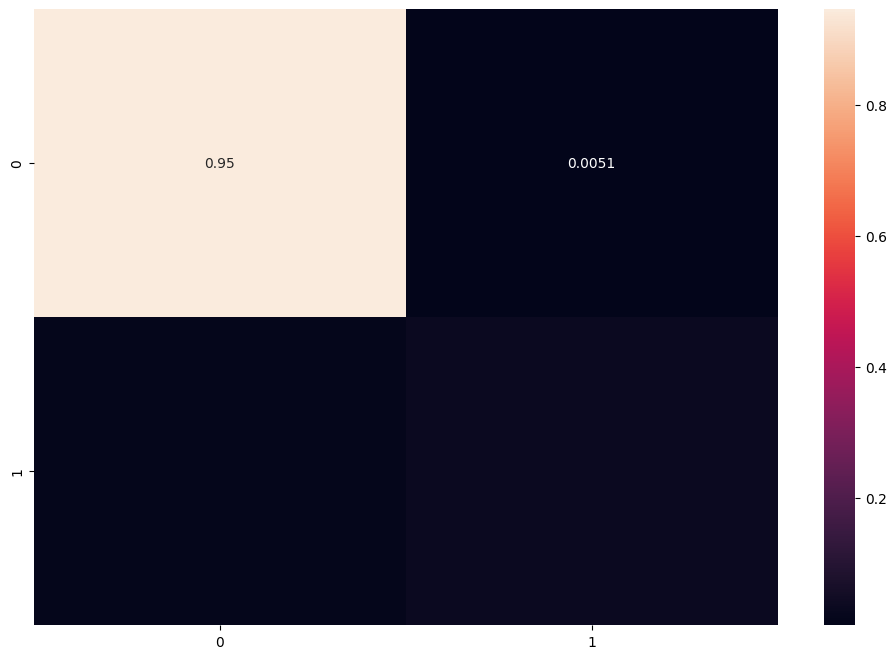

In [59]:
cf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True)

## Save Model

In [65]:
import joblib
joblib.dump(model, "job_detection.pkl")

['job_detection.pkl']

In [66]:
import joblib
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [ ]:
'''import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import pickle

# Load the model (assuming model is saved as 'model.pkl')
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Initialize the main window
root = tk.Tk()
root.title("Job Posting Fraud Detector")
root.geometry("600x400")'''

FileNotFoundError: [Errno 2] No such file or directory: 'model.pkl'

In [ ]:
df.head()

department  company_profile  description  requirements  benefits  \
0           1                1            1             1         0   
1           1                1            1             1         1   
2           0                1            1             1         0   
3           1                1            1             1         1   
4           0                1            1             1         1   

   telecommuting  has_company_logo  has_questions  employment_type  \
0              0                 1              0                1   
1              0                 1              0                1   
2              0                 1              0                0   
3              0                 1              0                1   
4              0                 1              1                1   

   required_experience  required_education  industry  function  fraudulent  \
0                    1                   0         0         1           0   
1                    1                   0         1         1           0   
2                    0                   0         0         0           0   
3                    1                   1         1         1           0   
4                    1                   1         1         1           0   

                                     job_description  description_length  
0  market food creat groundbreak award win cook s...                2685  
1  success second world cloud video product servi...                6169  
2  valor servic provid workforc solut meet need c...                2607  
3  sale passion improv qualiti life geographi hea...                5504  
4  spotsourc solut llc global human capit manag c...                4020

## Next Steps 

1. Deploy Model with Streamlit.

2. Continuously improve the model by training the model with more data, and further feature engineer and fine tune parameters.

3. Identify and fix errors to improve F1 Score after testing.

4. Model Transparency and Explainablility- Make sure the factors that cause a data point to be labeled fraudulent are transparent and explainable.
